# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Preprocessing 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
sns.set()

* Loading Data from sql database. Ignored neutral reviews that is score=3. And data is sorted according to time.

In [2]:
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')

data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


### Deduplication


* Same review from a user to a product in different time indicates duplicate data.
* Removed data that has same product ID, user id, score, text values.

In [3]:
# removing duplicates
data = data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

### Data Cleaning

* Removed html tags, punctuations from each sentence.
* Each word is lowercased and removed stop words(a, an, the....).
* Considered score 1 and 2 as negative review and scores 4 and 5 are considered as positive review.
* For negative review '0' as label and for positive review '1' as label.

In [4]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

snow = SnowballStemmer('english')
pre_processed = []

i = 0
N = len(data['Text'])
for sentence in data['Text']:    
    sentence = str(sentence)
    sentence = sentence.lower()
    clnr = re.compile('<.*?>') # for cleaning html tags
    sentence = re.sub(clnr, ' ', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', r' ', sentence) 
    
    words = [snow.stem(word) for word in sentence.split() \
             if word not in stopwords.words('english')]
    final_sentence = ''
    for word in words:
        final_sentence = final_sentence + word + ' '
    pre_processed.append(final_sentence)
    print("{0:.2f} %".format(i/N*100), end='\r')
    i += 1

data['Text'] = pre_processed

In [2]:
# loading pre processed data from hard disk that I previously processed
import pickle

with open('Saved/PreProcessed.pkl', 'rb') as f:
    data = pickle.load(f)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,witti littl book make son laugh loud recit car...,1
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,rememb see show air televis year ago child sis...,1
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,beetlejuic well written movi everyth excel act...,1
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,twist rumplestiskin captur film star michael k...,1
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,twist rumplestiskin captur film star michael k...,1


### Data Segmentation

* First 100k review taken into consideration.
* Taken only text column from data.
* Data is divided according to time.

In [3]:
data = data['Text'][0:10000]

# Bag of Words

* Trained bag of words by using training data. Transformed training and testing data to numerical vectors.
* Considered only top most 2000 important words.
* Each sentence is converted into a vector of size 2000.

In [4]:
# Training Bag of words
from sklearn.feature_extraction.text import CountVectorizer

bow_model = CountVectorizer(max_features=2000)
bow_data = bow_model.fit_transform(data)

## Clustering 

* Clustering text data into different clustering.
* Clustered using KMeans from sklearn.cluster module.
* Trained on bag of words data.

### KMeans++

* Algorithm for calculating intial values in KMeans.

In [5]:
from sklearn.cluster import KMeans

squared_distances = []
for i in range(8, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_jobs=3)
    kmeans.fit(bow_data)
    squared_distances.append(kmeans.inertia_)

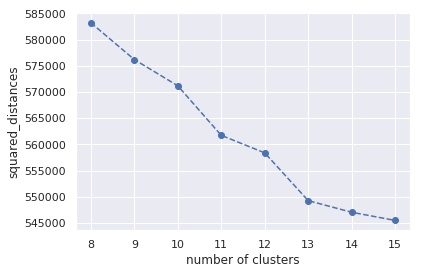

In [6]:
# plot 
te = [i for i in range(8,16)]
plt.plot(te, squared_distances, '--bo')
plt.xlabel('number of clusters')
plt.ylabel('squared_distances')
plt.show()

- According to elbow method, best model is of 13 clusters.

In [10]:
# training final model
kmeans = KMeans(n_clusters=13, init='k-means++', n_jobs=3)
kmeans.fit(bow_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=3, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
from prettytable import PrettyTable

performence = PrettyTable()
performence.field_names = ['Intialisation', 'num of clusters', 'squared distances']
performence.add_row(['KMeans++', 13, kmeans.inertia_])

Labelling each sentence to their respective cluster number and saving each cluster data into text data to read manually.

In [14]:
# loading not preprocessed data
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')
original_data = pd.read_sql_query("select * from Reviews where Score !=3 order by Time", conn)

# removing duplicates
original_data = original_data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

In [20]:
labels = kmeans.labels_
cluster_data = [[] for i in range(13)]

i = 0
for label in labels:
    cluster_data[label].append(original_data['Text'].iloc[i])
    i += 1

In [25]:
# saving 5th and 9th cluster data into text file


5

### Random Search

* Searching randomly for best depth.

In [17]:
# searching for best hyperparameter
from sklearn.model_selection import RandomizedSearchCV

parameters = {'max_depth':[i for i in range(1, 31)]}
classifier_ = DecisionTreeClassifier(class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=5, n_jobs=3)

In [18]:
search_hyp.fit(bow_train, Y_train)
search_hyp.best_params_

{'max_depth': 30}

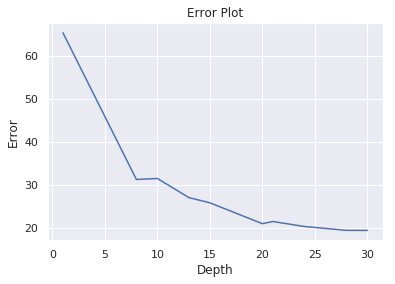

In [19]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['max_depth'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.show()

Optimal depth is 30.

In [20]:
# training final model
classifier = DecisionTreeClassifier(class_weight='balanced',
                                    max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(bow_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [21]:
pred = classifier.predict(bow_test)

tr_score = classifier.score(bow_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [22]:
performence.append(['Bag of Words', 'Random Search', search_hyp.best_params_['max_depth'], 
                   tr_score, accuracy, pre, rec, f1])

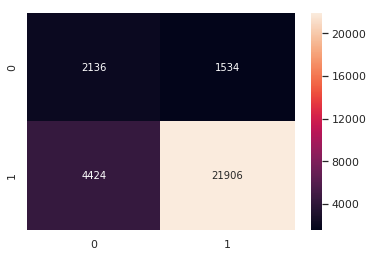

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

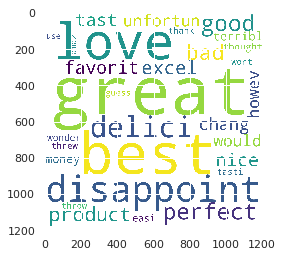

In [24]:
from wordcloud import WordCloud

te = {}
indices = np.array(list(map(abs, classifier.feature_importances_))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_importances_[ind_]
    
wordcloud = WordCloud(width = 1200, height = 1200, 
                background_color ='white', 
                min_font_size = 20).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

In [25]:
export_graphviz(classifier, out_file='tree2.dot', max_depth=30)

# Tf-Idf

* Trained tf-idf by using training data. Transformed training and testing data to numerical vectors.
* TfidfVectorizer from sklearn is used.
* Considered only top most 2000 important words.
* Each sentence is converted into a vector of size 2000.

In [26]:
# Training tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer(max_features=2000)
tfidf_train = tfidf_model.fit_transform(X_train)
tfidf_test = tfidf_model.transform(X_test)

## Decision Tree 

* Training Decision Tree using DecisionTreeClassifier from sklearn.tree module.
* Trained on tf-idf data.

### Grid Search

* Technique for searching for optimal depth.

In [27]:
# searching for best hyperparameter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[i for i in range(1, 32, 4)]}
classifier_ = DecisionTreeClassifier(class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=3)

In [28]:
search_hyp.fit(tfidf_train, Y_train)
search_hyp.best_params_

{'max_depth': 29}

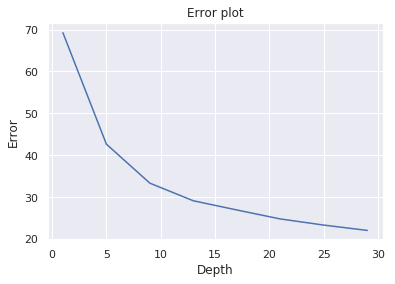

In [29]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['max_depth'], test_errors)
plt.title('Error plot')
plt.xlabel('Depth')
plt.ylabel('Error') 
plt.show()

Optimal depth is 29.

In [30]:
# training final model
classifier = DecisionTreeClassifier(class_weight='balanced',
                                    max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(tfidf_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=29, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [31]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(tfidf_test)

tr_score = classifier.score(tfidf_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [32]:
performence.append(['tf-idf', 'Grid Search', search_hyp.best_params_['max_depth'], 
                   tr_score, accuracy, pre, rec, f1])

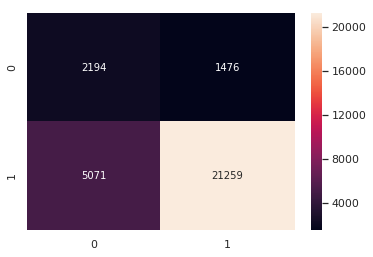

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

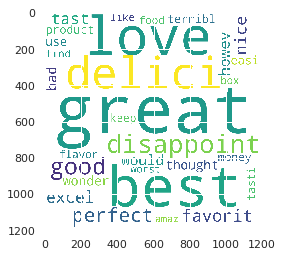

In [34]:
te = {}
indices = np.array(list(map(abs, classifier.feature_importances_))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_importances_[ind_]
    
wordcloud = WordCloud(width = 1200, height = 1200, 
                background_color ='white', 
                min_font_size = 20).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

In [35]:
export_graphviz(classifier, out_file='tree3.dot', max_depth=30)

### Random Search

* Searching randomly for best depth.

In [36]:
# searching for best hyperparameter
parameters = {'max_depth':[i for i in range(1, 31)]}
classifier_ = DecisionTreeClassifier(class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=5, n_jobs=3)

In [37]:
search_hyp.fit(tfidf_train, Y_train)
search_hyp.best_params_

{'max_depth': 26}

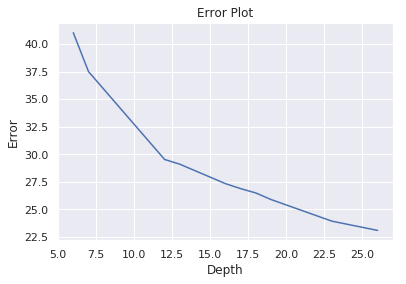

In [38]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['max_depth'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.show()

Optimal depth is 26.

In [39]:
# training final model
classifier = DecisionTreeClassifier(class_weight='balanced',
                                    max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(tfidf_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=26, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [40]:
pred = classifier.predict(tfidf_test)

tr_score = classifier.score(tfidf_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [41]:
performence.append(['tf-idf', 'Random Search', search_hyp.best_params_['max_depth'], 
                   tr_score, accuracy, pre, rec, f1])

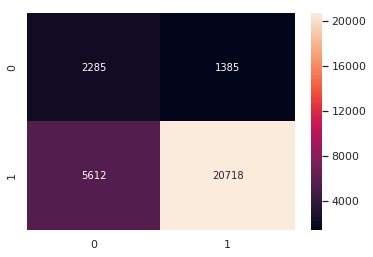

In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

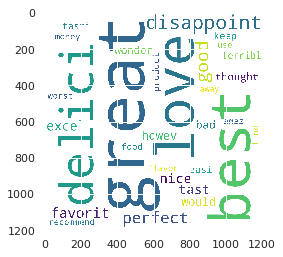

In [43]:
te = {}
indices = np.array(list(map(abs, classifier.feature_importances_))).argsort()[1970:2000]
indices = indices.tolist()
for ind_ in indices:
    for word in bow_model.vocabulary_:
        if bow_model.vocabulary_[word] == ind_:
            te[word] = classifier.feature_importances_[ind_]
    
wordcloud = WordCloud(width = 1200, height = 1200, 
                background_color ='white', 
                min_font_size = 20).generate_from_frequencies(te)
plt.imshow(wordcloud)
plt.show()

In [44]:
export_graphviz(classifier, out_file='tree3.dot', max_depth=30)

# Word2vec

* Trained own word2vec using gensim module. Considered words which has frequency more than 5 in whole data.
* Trained word2vec using Word2vec function from gensim.models.
* Trained for vector of size 150. And converted each word into a vector of size 150.
* Added all vectors of a sentence and divided with total number of vectors in sentence. So that we can get average word2vec value for each sentence.

In [45]:
import warnings
warnings.filterwarnings("ignore")

# training word2vec on training data
from gensim.models import Word2Vec
sentences = []
for row in X_train:
    sentences.append([word for word in row.split()])

w2v = Word2Vec(sentences, min_count=5, size=150, workers=3)
avgw2v_train = []
for row in sentences:
    te = [0 for i in range(150)]
    num = 0
    for word in row:
        try:
            te += w2v[word]
            num += 1
        except:
            pass
    avgw2v_train.append(te/num)

In [46]:
# converting test data

sentences = []
for row in X_test:
    sentences.append([word for word in row.split()])

avgw2v_test = []
for row in sentences:
    te = [0 for i in range(150)]
    num = 0
    for word in row:
        try:
            te += w2v[word]
            num += 1
        except:
            pass
    avgw2v_test.append(te/num)

## Decision Tree 

* Training Decision Tree using DecisionTreeClassifier from sklearn.tree module.
* Trained on Average word2vec data.

### Grid Search

* Technique for searching for optimal depth.

In [47]:
# searching for best hyperparameter

parameters = {'max_depth':[i for i in range(1, 152, 25)]}
classifier_ = DecisionTreeClassifier(class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=3)

In [48]:
search_hyp.fit(avgw2v_train, Y_train)
search_hyp.best_params_

{'max_depth': 126}

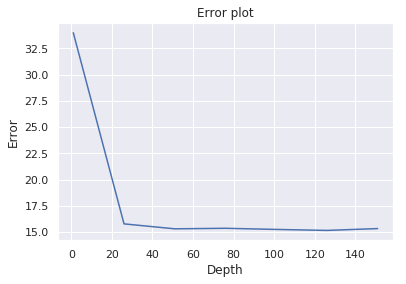

In [49]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['max_depth'], test_errors)
plt.title('Error plot')
plt.xlabel('Depth')
plt.ylabel('Error') 
plt.show()

Optimal depth is 126.

In [50]:
# training final model
classifier = DecisionTreeClassifier(class_weight='balanced',
                                    max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(avgw2v_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=126, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [51]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(avgw2v_test)

tr_score = classifier.score(avgw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [52]:
performence.append(['Avg word2vec', 'Grid Search', search_hyp.best_params_['max_depth'], 
                   tr_score, accuracy, pre, rec, f1])

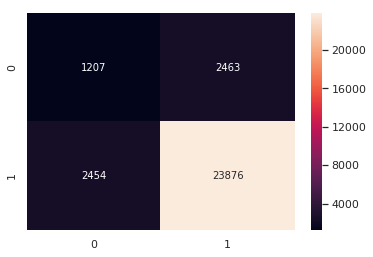

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

### Random Search

* Searching randomly for best depth.

In [54]:
# searching for best hyperparameter
parameters = {'max_depth':[i for i in range(1, 152, 5)]}
classifier_ = DecisionTreeClassifier(class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=5, n_jobs=3)

In [55]:
search_hyp.fit(avgw2v_train, Y_train)
search_hyp.best_params_

{'max_depth': 111}

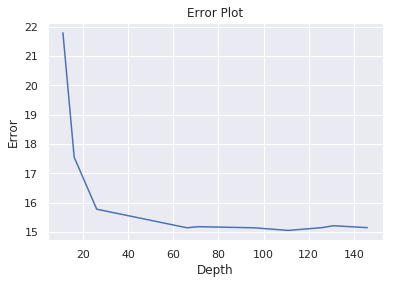

In [56]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['max_depth'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.show()

Optimal depth is 111.

In [57]:
# training final model
classifier = DecisionTreeClassifier(class_weight='balanced',
                                    max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(avgw2v_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=111, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [58]:
pred = classifier.predict(avgw2v_test)

tr_score = classifier.score(avgw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [59]:
performence.append(['Avg word2vec', 'Random Search', search_hyp.best_params_['max_depth'], 
                   tr_score, accuracy, pre, rec, f1])

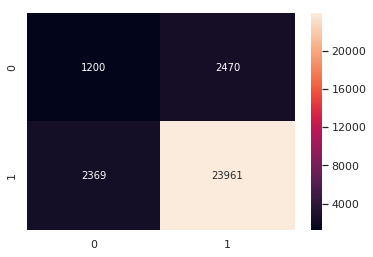

In [60]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

# Tf-IDF word2vec

* Using pre-trained tf-idf vectors and word2vec of size 150.
* Multiplying each word's word2vec vector and tf-idf value of that word in respected sentence.
* Executing above step for each word in a sentence and took sum of values of all words in a sentence.
* And this sum is divided by sum of tf-idf values of all words in sentences. Finally gives tf-idf word2vec values of size 150 for each sentence.

In [61]:
tfidf_train = tfidf_train.toarray()
tfidf_test = tfidf_test.toarray()

In [63]:
sentences = []
for row in X_train:
    sentences.append([word for word in row.split()])

tfidfw2v_train = []
i = 0
for row in sentences:
    te = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tfidf_train[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    num = 0
    tf_idf_sum = 0
    for word in row:
        try:
            num += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[num-1]
            te += (temp_tfidf[num-1] * w2v[word])
        except:
            pass
    try: # avoiding divide by zero
        te = (float)(1/tf_idf_sum) * te
    except:
        pass
    tfidfw2v_train.append(te)
    i = i + 1

In [64]:
sentences = []
for row in X_test:
    sentences.append([word for word in row.split()])

tfidfw2v_test = []
i = 0
for row in sentences:
    te = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tfidf_test[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    num = 0
    tf_idf_sum = 0
    for word in row:
        try:
            num += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[num-1]
            te += (temp_tfidf[num-1] * w2v[word])
        except:
            pass
    try: # avoiding divide by zero
        te = (float)(1/tf_idf_sum) * te
    except:
        pass
    tfidfw2v_test.append(te)
    i = i + 1

## Decision Tree 

* Training Decision Tree using DecisionTreeClassifier from sklearn.tree module.
* Trained on tf-idf word2vec data.

### Grid Search

* Technique for searching for optimal depth.

In [65]:
class_weight='balanced'# searching for best hyperparameter

parameters = {'max_depth':[i for i in range(1, 152, 25)]}
classifier_ = DecisionTreeClassifier(class_weight='balanced')

search_hyp = GridSearchCV(classifier_, parameters, cv=5, n_jobs=3)

In [66]:
search_hyp.fit(tfidfw2v_train, Y_train)
search_hyp.best_params_

{'max_depth': 51}

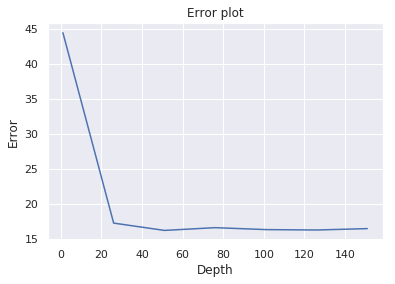

In [67]:
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

plt.plot(parameters['max_depth'], test_errors)
plt.title('Error plot')
plt.xlabel('Depth')
plt.ylabel('Error')
plt.show()

Optimal depth is 51.

In [68]:
# training final model
classifier = DecisionTreeClassifier(class_weight='balanced',
                                    max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(tfidfw2v_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=51, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [69]:
# performence metrics

from sklearn import metrics
pred = classifier.predict(tfidfw2v_test)

tr_score = classifier.score(tfidfw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [70]:
performence.append(['tf-idf word2vec', 'Grid Search', search_hyp.best_params_['max_depth'], 
                   tr_score, accuracy, pre, rec, f1])

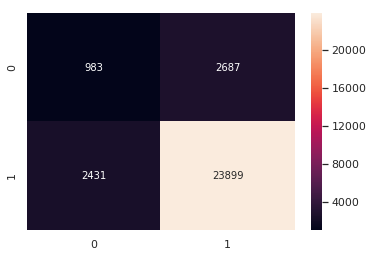

In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

In [72]:
export_graphviz(classifier, out_file='tree4.dot', max_depth=30)

### Random Search

* Searching randomly for best depth.

In [73]:
# searching for best hyperparameter
parameters = {'max_depth':[i for i in range(1, 152, 5)]}
classifier_ = DecisionTreeClassifier(class_weight='balanced')

search_hyp = RandomizedSearchCV(classifier_, parameters, cv=5, n_jobs=3)

In [74]:
search_hyp.fit(tfidfw2v_train, Y_train)
search_hyp.best_params_

{'max_depth': 111}

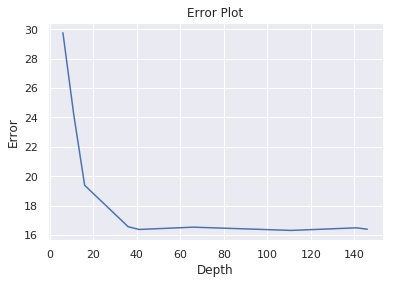

In [75]:
te = []
for i in range(10):
    te.append(search_hyp.cv_results_['params'][i]['max_depth'])
indices = np.argsort(te).tolist()
test_errors = [(1-i)*100 for i in search_hyp.cv_results_['mean_test_score']]

temp1 = []
temp2 = []
for ind in indices:
    temp1.append(te[ind])
    temp2.append(test_errors[ind])
    
plt.plot(temp1, temp2)
plt.title('Error Plot')
plt.xlabel("Depth")
plt.ylabel("Error")
plt.show()

Optimal depth is 111.

In [76]:
# training final model
classifier = DecisionTreeClassifier(class_weight='balanced',
                                    max_depth=search_hyp.best_params_['max_depth'])
classifier.fit(tfidfw2v_train, Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=111, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [77]:
pred = classifier.predict(tfidfw2v_test)

tr_score = classifier.score(tfidfw2v_train, Y_train)
accuracy = metrics.accuracy_score(Y_test, pred)
pre = metrics.precision_score(Y_test, pred)
rec = metrics.recall_score(Y_test, pred)
f1 = metrics.f1_score(Y_test, pred)

In [78]:
performence.append(['tf-idf word2vec', 'Random Search', search_hyp.best_params_['max_depth'], 
                   tr_score, accuracy, pre, rec, f1])

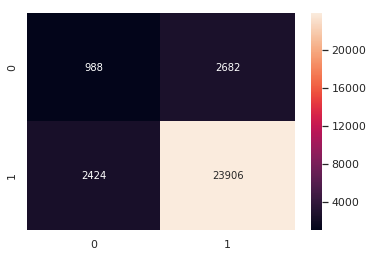

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, pred)
sns.heatmap(cm, annot=True, fmt='d')

In [80]:
export_graphviz(classifier, out_file='tree5.dot', max_depth=30)

# Conclusion

In [81]:
pd.DataFrame(performence, columns=header)

,Vectorizer,Search Algo,depth,Train accuracy,Test accuracy,Precision,Recall,f1-score
0,Bag of Words,Grid Search,29,0.890471,0.800000,0.935071,0.829738,0.879261
1,Bag of Words,Random Search,30,0.894900,0.801400,0.934556,0.831979,0.880289
2,tf-idf,Grid Search,29,0.879243,0.781767,0.935078,0.807406,0.866565
3,tf-idf,Random Search,26,0.858229,0.766767,0.937339,0.786859,0.855532
4,Avg word2vec,Grid Search,126,0.999986,0.836100,0.906488,0.906798,0.906643
5,Avg word2vec,Random Search,111,0.999986,0.838700,0.906549,0.910027,0.908285
6,tf-idf word2vec,Grid Search,51,0.998914,0.829400,0.898932,0.907672,0.903281
7,tf-idf word2vec,Random Search,111,0.999986,0.829800,0.899127,0.907938,0.903511


* Got good accuracy with Decision Trees of depth 126 & 111 and Average word2vec vectorizer.
* Got better precision with Decision Trees of depth 29, 30, 26 and bag of words, tf-idf vectorizer.